In [2]:
%load_ext autoreload
%autoreload 2
import torch

import numpy as np
import matplotlib.pyplot as plt

from deeplift_shap import DeepLiftShap

from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast.models import SlowFast, load_checkpoint
from diveslowlearnfast.config import Config

import logging

In [3]:
logging.basicConfig(level=logging.DEBUG)

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 24
cfg.DATA.NUM_FRAMES = 8
cfg.DATA.TRAIN_CROP_SIZE = 256
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, train_loader, *_ = train_helper.get_train_objects(cfg, model)
model, *_ = load_checkpoint(model, optimiser, '../misc/checkpoint.pth', device)
dl = DeepLiftShap(model)

test_loader = train_helper.get_test_objects(cfg)

In [4]:
baseline_values, *_ = next(iter(train_loader))
baseline_values.shape

torch.Size([24, 3, 8, 256, 256])

In [6]:
x, y, *_ = next(iter(test_loader))
y = y[0]
x = x[0].unsqueeze(0)
x_fast = x[:]
# reduce the number of frames by the alpha ratio
# B x C x T / alpha x H x W
B, C, T, H, W = x.shape
x_slow = x[:, :, ::cfg.SLOWFAST.ALPHA]
input = [x_slow, x_fast]

In [7]:
# generate 100 baseline samples with black pixels
# baseline_values = torch.zeros((20, *x.shape[1:]))
baseline_dist_fast = baseline_values[:]
baseline_dist_slow = baseline_values[:, :, ::cfg.SLOWFAST.ALPHA]
baselines = [baseline_dist_slow, baseline_dist_fast]
attributions_slow, attributions_fast = dl.attribute(input, baselines, y, n_samples=20)

print('attribution completed printing shapes for slow and fast input components:')
print(attributions_slow.shape, attributions_fast.shape)
alpha = cfg.SLOWFAST.ALPHA
t, h, w = attributions_slow.shape
slow_maps_upsampled = torch.zeros((t * alpha, H, W))
for i in range(t):
    slow_maps_upsampled[i*alpha:(i+1)*alpha] = attributions_slow[i]

# Combine pathways
combined_maps = (slow_maps_upsampled + attributions_fast) / 2

# Normalize
max_val = torch.max(torch.abs(combined_maps))
normalized_maps = combined_maps / (max_val + 1e-10)
print(normalized_maps.shape)

torch.Size([60, 3, 1, 256, 256]) torch.Size([60, 3, 8, 256, 256])
torch.Size([3, 20, 3, 1, 256, 256]) torch.Size([3, 20, 3, 8, 256, 256])
attribution completed printing shapes for slow and fast input components:
torch.Size([1, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 256, 256])


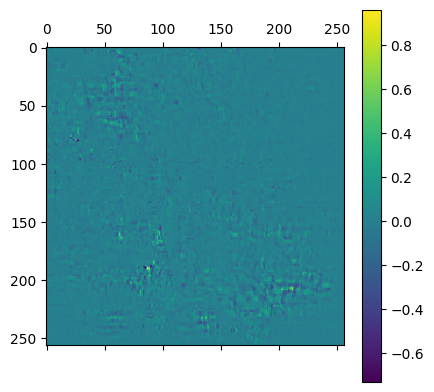

In [8]:
plt.matshow(normalized_maps.detach().cpu().numpy()[0])
plt.colorbar()
plt.show()

In [9]:
input = x.squeeze().detach().cpu().numpy().transpose(1, 2, 3, 0)
attribution_maps = normalized_maps.detach().cpu().numpy()
input.shape, attribution_maps.shape

((8, 256, 256, 3), (8, 256, 256))

In [11]:
def normalise(x):
    return (x - x.min()) / (x.max() - x.min())

def denormalize(frames, mean, std, dtype=np.float32):
    if type(mean) != np.ndarray:
        mean = np.array(mean)

    if type(std) != np.ndarray:
        std = np.array(std)

    frames = frames * np.array(std)[None, None, None, :] + np.array(mean)[None, None, None, :]
    if dtype == np.float32:
        return frames

    return np.uint8(frames)

def normalize_attributions(attribution_map):
    """
    Normalize attribution values to range [-1, 1]
    """
    abs_max = np.abs(attribution_map).max()
    if abs_max == 0:
        return attribution_map
    return attribution_map / abs_max

def create_color_overlay(attribution_map):
    """
    Create RGB overlay where:
    - Red channel represents negative attributions
    - Blue channel represents positive attributions
    - Intensity scales with attribution strength
    """
    # Initialize RGB array
    height, width = attribution_map.shape
    overlay = np.zeros((height, width, 3))

    # Separate positive and negative attributions
    pos_attr = np.maximum(0, attribution_map)
    neg_attr = np.abs(np.minimum(0, attribution_map))

    # Set red channel (negative attributions)
    overlay[:, :, 0] = neg_attr

    # Set blue channel (positive attributions)
    overlay[:, :, 2] = pos_attr

    return overlay

def visualize_attributions(attribution_map, original_image=None, alpha=0.5):
    """
    Create visualization of attribution map with color overlay.

    Parameters:
    -----------
    attribution_map : numpy.ndarray
        2D array of attribution values
    original_image : numpy.ndarray or None, optional
        Original image to overlay attributions on (should be in range [0,1])
    alpha : float, optional
        Transparency of the attribution overlay (0 to 1)

    Returns:
    --------
    numpy.ndarray
        RGB image with attribution overlay
    """
    # Normalize attribution values to [-1, 1]
    # normalized_map = normalize_attributions(attribution_map)

    # Create color overlay
    overlay = create_color_overlay(attribution_map)

    if original_image is not None:
        # Ensure original image is in range [0,1]
        if original_image.max() > 1:
            original_image = original_image / 255.0

        # Convert grayscale to RGB if necessary
        if len(original_image.shape) == 2:
            original_image = np.stack([original_image] * 3, axis=-1)

        # Blend original image with overlay
        visualization = (1 - alpha) * original_image + alpha * overlay
    else:
        visualization = overlay

    # Ensure output is in valid range [0,1]
    visualization = np.clip(visualization, 0, 1)

    return visualization


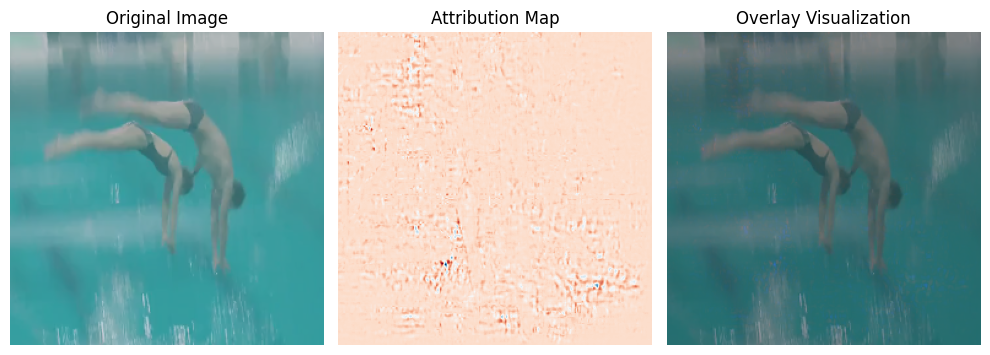

In [13]:
idx = 5
temp = input.copy()
temp = denormalize(temp, cfg.DATA.MEAN, cfg.DATA.STD)[idx]
attr_map = attribution_maps[idx]

viz = visualize_attributions(attr_map, original_image=temp, alpha=0.3)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.title("Original Image")
plt.imshow(temp, cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title("Attribution Map")
plt.imshow(attr_map, cmap='RdBu')
plt.axis('off')

plt.subplot(133)
plt.title("Overlay Visualization")
plt.imshow(viz)
plt.axis('off')

plt.tight_layout()
plt.show()